In [2]:
import h5py
import brighteyes_flim
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu as otsu


In [5]:
#close previously opened .h5 files. If you don't have any .h5 file opened skip this cell

import gc
for obj in gc.get_objects():   # Browse through ALL objects
    if isinstance(obj, h5py.File):   # Just HDF5 files
        try:
            print(obj)
            obj.close()
        except:
            pass # Was already closed

<Closed HDF5 file>
<Closed HDF5 file>
<Closed HDF5 file>
<HDF5 file "06_Convallaria_LP51.h5" (mode r)>


In [ ]:
# If you want to process the raw data acquired with the DFD architecture, you can reate an instance of the 
# FlimData class to load the FLIM dataset related to the acquired image. 

# two .h5 files' path need to be provided as inputs to the class:
# 1) The reference/calibration sample file path 
# 2) The investigated sample file path 

# The reference sample image is recorded and processed to calculate the IRF-associated phasor.
# This value is used to correct the IRF contribution in the phasor of the investigated sample

# When creating and running the instance of the FlimData class, an .h5 file is created, 
# storing the decay histograms in each pixel (for the DFD achitecture the histograms 
# are realigned with respect to the signal which triggers the beginning of the excitation)

print(brighteyes_flim.__file__)
flim_ref=brighteyes_flim.FlimData(data_path = r"C:\Users\fdelbufalo\Desktop\images\data-07-12-2023-20-32-34.h5",                                   
                                  data_path_irf = r"C:\Users\fdelbufalo\Desktop\images\data-07-12-2023-20-08-30.h5",
                                  pre_filter=0.1)                    

In [2]:
 # Use the method 'calculate_phasor_on_img_pixels' to get a H5 file storing the phasor in each pixel 
 # computed from the pixels' histogram contained in a .h5 file 
 # If you want to process the file containg the pixels' histograms acquired with the DFD architecture, 
 # you have to open the .h5 file "dataset_of_pixel_histogram_aligned" and use the key "h5_dataset"
 # to access to the h5 dataset storing the histograms in each pixel
 # If you want to process the .h5 file containig the histograms' data of each pixel acquired with 
 # the BrightEyes TTM you have to open the .h5 file "dataset_of_pixel_histogram_aligned_ttm" and use 
 # the correspondent key to access to the h5 dataset storing the histograms in each pixel 

with h5py.File(r"C:\Users\fdelbufalo\Desktop\images\convallaria_03_07_2024.h5","a") as f:
    
        print(f.keys())
        data_input = f["dataset_1"]  # image with the decay histograms in each pixel realigned 
                                     # with respect to the signal which triggers the beginning of the excitation

        fasors = brighteyes_flim.calculate_phasor_on_img_pixels(data_path = r"C:\Users\fdelbufalo\Desktop\images\convallaria_03_07_2024.h5", data_input = data_input) 

<KeysViewHDF5 ['dataset_1']>


<KeysViewHDF5 ['dataset_1']>
(1024, 1024)


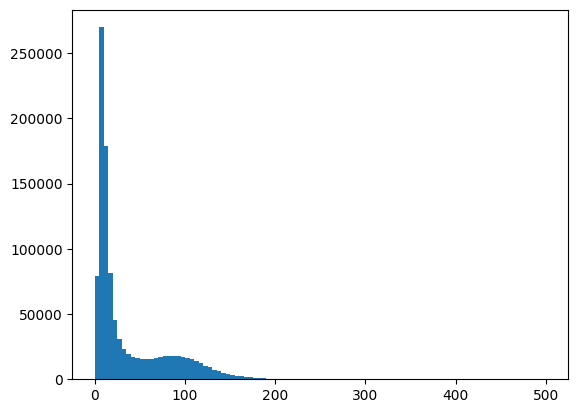

In [3]:
# Compute the 2D (x,y) image with histograms realigned in each pixel (photon counts in each pixel)
with h5py.File(r"C:\Users\fdelbufalo\Desktop\images\convallaria_03_07_2024.h5","a") as f:
    
        print(f.keys())
        data_input = f["dataset_1"]
        
        data_histograms = np.sum(data_input, axis = (2, 3))
        print(data_histograms.shape)
    
# Plot the histogram of the photon counts in each pixel to see the distribution (e.g. check the level of noise) 
        plt.figure()
        plt.hist(data_histograms.flatten(), bins = 100, range = (0, 500))

In [4]:
print(data_histograms.shape)


(2000, 2000)


In [4]:
# Process the histograms in each pixel to remove the pixels with a low amount of signal

# We want to process the histogram counts matrix and the tau matrix 
# to check if the pixels with high counts have only tau positives 

from skimage.filters import threshold_otsu as otsu
histograms_filtered = otsu(image=data_histograms, nbins=50)
print(histograms_filtered)
hist_indexes = np.argwhere(data_histograms > 70)
histogram_denoised = data_histograms[hist_indexes[:, 0], hist_indexes[:, 1]]
print(histogram_denoised)
print(hist_indexes.shape)

393.57
[   77.    71.    76. ...    99.    74. 13119.]
(219146, 2)


<KeysViewHDF5 ['h5_dataset_phasor_pix']>
(1024, 1024)


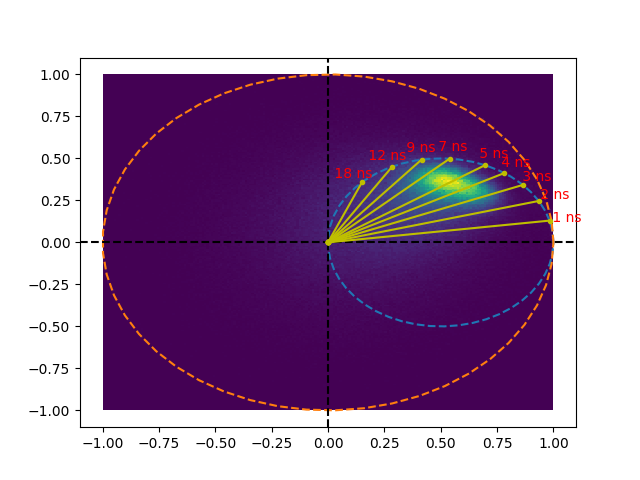

In [5]:
# Display the pixels'histogram-associated phasors in the phasor plot

%matplotlib widget

hf_phasors_per_pixel = h5py.File('convallaria_phasors', "r")
print(hf_phasors_per_pixel.keys())

phasors_pix = hf_phasors_per_pixel["h5_dataset_phasor_pix"]  # data with phasors in each pixel
#fasors_pix[1:100, 1:100]
print(phasors_pix.shape)

brighteyes_flim.plot_phasor(phasors_pix[:], bins_2dplot=200, log_scale=False)

In [6]:
# Calculate the single pixels' tau (fluorescence lifetime) values from the phasors of each pixel 

tau_phi = brighteyes_flim.calculate_tau_phi(np.real(phasors_pix[:]), np.imag(phasors_pix[:]))
print(tau_phi.shape)
print(tau_phi)

#tau_flatten method

(1024, 1024)
[[            nan             nan             nan ...             nan
              nan             nan]
 [            nan  5.19169167e-09 -3.08573438e-09 ...  3.26511446e-09
   7.07626302e-09  6.65334866e-09]
 [            nan  7.54315249e-09 -7.89633871e-09 ...  3.35908779e-09
   5.96602794e-09  7.91222810e-09]
 ...
 [            nan             nan  7.76420621e-09 ...  1.08046433e-08
   4.91716805e-09  7.04800891e-09]
 [            nan -1.49537417e-07  7.89592059e-08 ...  6.20818521e-09
   7.02232366e-09  9.63950983e-09]
 [            nan  7.24211608e-09  1.29172503e-08 ...  8.78583110e-09
   1.33424280e-08             nan]]


In [15]:
file_path = r"C:\Users\fdelbufalo\Desktop\lifetime_convallaria.npz"

# Save the data to the NPZ file
np.savez(file_path, tau_phi)


[6.08388661e-09 5.47548455e-09 7.19613927e-09 ... 8.71788315e-09
 5.58216730e-09            nan]


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 1.000e+01,
        1.500e+01, 1.700e+01, 2.400e+01, 3.500e+01, 7.000e+01, 1.220e+02,
        1.960e+02, 2.580e+02, 4.010e+02, 5.690e+02, 8.020e+02, 1.046e+03,
        1.449e+03, 1.737e+03, 2.172e+03, 2.685e+03, 3.025e+03, 3.538e+03,
        3.950e+03, 4.319e+03, 4.661e+03, 4.928e+03, 5.113e+03, 5.352e+03,
        5.404e+03, 5.501e+03, 5.706e+03, 5.666e+03, 5.567e+03, 5.659e+03,
        5.765e+03, 5.655e+03, 5.591e+03, 5.804e+03, 5.635e+03, 5.643e+03,
        5.606e+03, 5.625e+03, 5.506e+03, 5.282e+03, 5.384e+03, 5.063e+03,
        4.992e+03, 4.743e+03, 4.570e+03, 4.287e+03, 4.040e+03, 3.897e+03,
        3.542e+03, 3.458e+03, 3.204e+03, 3.101e+03, 2.785e+03, 2.459e+03,
        2.380e+03, 2.171e+03, 1.979e+03, 1.762e+03, 1.671e+03, 1.516e+03,
        1.511e+03, 1.266e+03, 1.146e+0

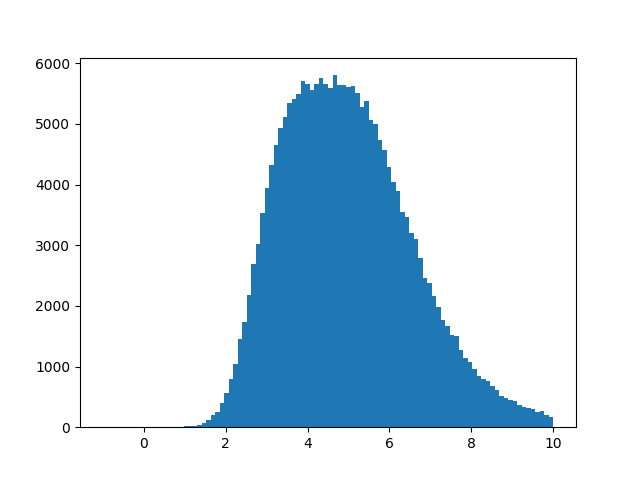

In [7]:
# Select the tau only from the pixels having a sufficient amount of photons, 
# identified applying an image thresholding method (e.g., Otsu's method).

tau_phi_denoised = tau_phi[hist_indexes[:, 0], hist_indexes[:, 1]]
print(tau_phi_denoised)
plt.figure()
plt.hist(1e9*tau_phi_denoised, bins = 100, range = (-1, 10))


In [16]:
file_path = r"C:\Users\fdelbufalo\Desktop\lifetime_convallaria_thresholded.npz"

# Save the data to the NPZ file
np.savez(file_path, tau_phi)

(array([ 3134.,  3216.,  3446.,  3608.,  3969.,  4097.,  4301.,  4663.,
         4870.,  5117.,  5417.,  5843.,  6157.,  6703.,  7193.,  7631.,
         8096.,  8828.,  9561., 10193., 11027., 12039., 13337., 14804.,
        17256., 20700., 25545., 31530., 36333., 39995., 41513., 41523.,
        40759., 39842., 37727., 35575., 32506., 29314., 26040., 22651.,
        19501., 16850., 14528., 12570., 11054.,  9644.,  8588.,  7553.,
         7016.,  6295.]),
 array([-6.  , -5.68, -5.36, -5.04, -4.72, -4.4 , -4.08, -3.76, -3.44,
        -3.12, -2.8 , -2.48, -2.16, -1.84, -1.52, -1.2 , -0.88, -0.56,
        -0.24,  0.08,  0.4 ,  0.72,  1.04,  1.36,  1.68,  2.  ,  2.32,
         2.64,  2.96,  3.28,  3.6 ,  3.92,  4.24,  4.56,  4.88,  5.2 ,
         5.52,  5.84,  6.16,  6.48,  6.8 ,  7.12,  7.44,  7.76,  8.08,
         8.4 ,  8.72,  9.04,  9.36,  9.68, 10.  ]),
 <BarContainer object of 50 artists>)

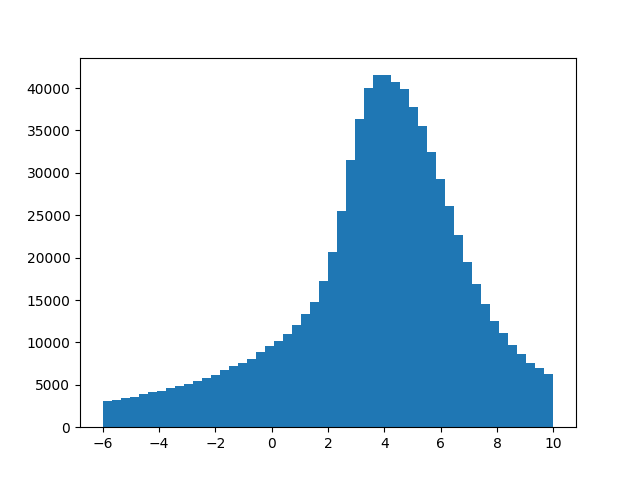

In [8]:
# Plot the distribution of tau values in all the pixels of the image 
tau_data = 1e9*tau_phi.flatten()

plt.figure()
plt.hist(tau_data, range = (-6, 10), bins = 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.25000000e-01, 7.11631870e-03],
         [3.99999991e-03, 0.00000000e+00, 4.99999989e-03],
         ...,
         [2.89999992e-01, 2.57675309e-01, 0.00000000e+00],
         [0.00000000e+00, 2.60048549e-01, 3.24999988e-01],
         [0.00000000e+00, 5.74999988e-01, 5.42437333e-01]],
 
        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 5.16998912e-02, 1.00000001e-01],
         [4.79999989e-02, 0.00000000e+00, 5.99999987e-02],
         ...,
         [2.00000003e-01, 1.89105359e-01, 0.00000000e+00],
        

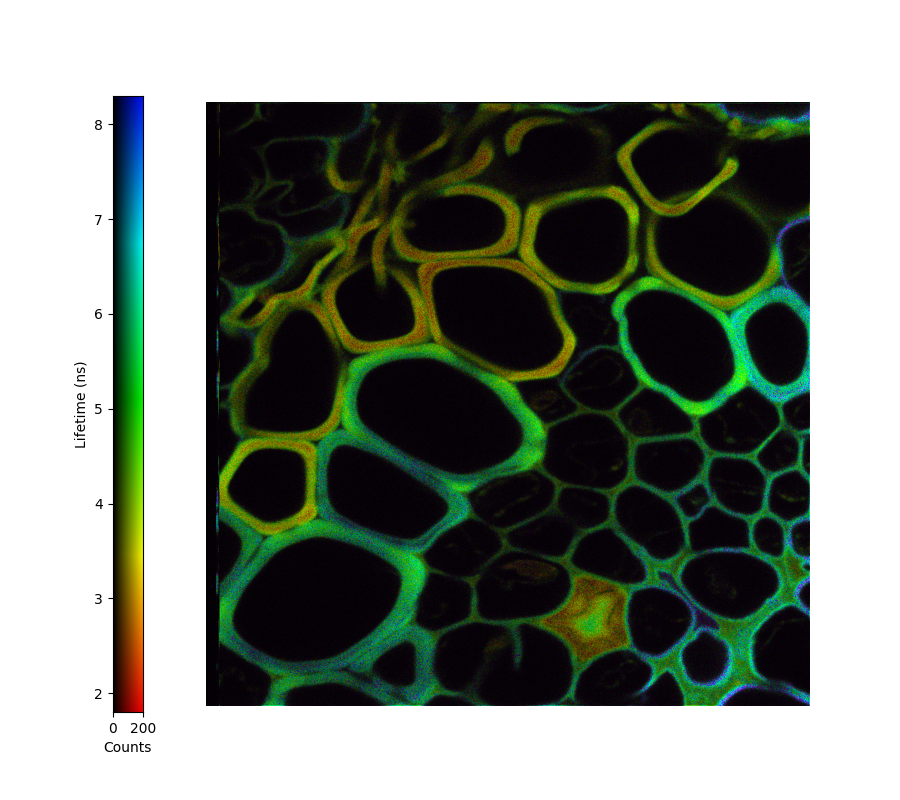

In [9]:
# Apply the method showFLIM contained in brighteyes_flim library to plot the FLIM image
# given the intensity array and the array storing the lifetime values in each pixel

# It is possible to manually select the extremes of the fluorescence lifetime values 
# (minimum and max lifetimes present in the image).   
# If the bounds of tau are not specified, they are automatically calculated by showFLIM
# method applying an Otsu's method on the intensity image and selecting the lifetimes 
# associated to the pixels having a minimum amount of photon counts as calculated by the Otsu's method

bounds_Tau = {
            "minTau": 1.8,
            "maxTau": 8.3,
        }

bounds_Int = {
            "minInt": 0,
            "maxInt": 200,
        }


brighteyes_flim.showFLIM(data_histograms, tau_phi*1e9, bounds_tau = bounds_Tau,  bounds_int = bounds_Int)   